In [31]:
import random
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem, Descriptors
import scipy

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import logging
optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.CRITICAL)

In [33]:
electron_affinities = {
    'Br':324.6,
    'Se':79.9,
    'se':79.9,
    'I':126.9,
    'H': 72.8,
    'Li': 59.6,
    'Be': -48,
    'B': 26.7,
    'C': 121.8,
    'c': 121.8,
    'N': 7.0,
    'O': 140.4,
    'o': 140.4,
    'F': 328.0,
    'Na': 52.8,
    'Mg': -40,
    'Al': 42.5,
    'Si': 134.1,
    'P': 72.0,
    'S': 200.0,
    's': 200.0,
    'Cl': 349.0
}

wtd_electron_affinities = {
    'Br':324.6,
    'Se':79.9,
    'I':126.9,
    'H': 72.8,
    'Li': 59.6,
    'Be': -48,
    'B': 26.7,
    'C': 121.8,
    'N': 7.0,
    'O': 140.4,
    'F': 328.0,
    'Na': 52.8,
    'Mg': -40,
    'Al': 42.5,
    'Si': 134.1,
    'P': 72.0 * 1.2,
    'S': 200.0 * 1.5,
    'Cl': 349.0
}

element_properties = {
    'Br':{'Atomic_weight': 79.904, 'Natural_abundance': 50.69},
    'Se':{'Atomic_weight': 78.96, 'Natural_abundance': 49.61},
    'se':{'Atomic_weight': 78.96, 'Natural_abundance': 49.61},
    'I':{'Atomic_weight': 126.904, 'Natural_abundance': 100},
    'H': {'Atomic_weight': 1.008, 'Natural_abundance': 99.985},
    'Li': {'Atomic_weight': 6.94, 'Natural_abundance': 92.58},
    'Be': {'Atomic_weight': 9.012, 'Natural_abundance': 100},
    'B': {'Atomic_weight': 10.81, 'Natural_abundance': 80.1},
    'C': {'Atomic_weight': 12.011, 'Natural_abundance': 98.93},
    'c': {'Atomic_weight': 12.011, 'Natural_abundance': 98.93},
    'N': {'Atomic_weight': 14.007, 'Natural_abundance': 99.63},
    'O': {'Atomic_weight': 15.999, 'Natural_abundance': 99.76},
    'o': {'Atomic_weight': 15.999, 'Natural_abundance': 99.76},
    'F': {'Atomic_weight': 18.998, 'Natural_abundance': 100},
    'Na': {'Atomic_weight': 22.990, 'Natural_abundance': 100},
    'Mg': {'Atomic_weight': 24.305, 'Natural_abundance': 78.99},
    'Al': {'Atomic_weight': 26.982, 'Natural_abundance': 100},
    'Si': {'Atomic_weight': 28.085, 'Natural_abundance': 92.23},
    'P': {'Atomic_weight': 30.974, 'Natural_abundance': 100},
    'S': {'Atomic_weight': 32.06, 'Natural_abundance': 95.02},
    's': {'Atomic_weight': 32.06, 'Natural_abundance': 95.02},
    'Cl': {'Atomic_weight': 35.45, 'Natural_abundance': 75.78},
}

In [34]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 8, nBits=4096*2)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

seed_everything(42) # Seed 고정


class CustomDataset(Dataset):
    def __init__(self, df, target):
        self.df = df
        self.target = target # HLM or MLM

        self.feature_select = transform
        self.fp = self.feature_select.fit_transform(np.stack(df['FPs']))

    def __getitem__(self, index):
        fp = self.fp[index]
        return torch.tensor(fp).float() # feature
        
    def __len__(self):
        return len(self.df)
    
def HLM_make_train_val(train1, val1):
    train1_y = train1["HLM"]
    train1_x = train1.iloc[:,4:]

    val1_y = val1["HLM"]
    val1_x = val1.iloc[:,4:]
    return train1_x, train1_y, val1_x, val1_y

def MLM_make_train_val(train1, val1):
    train1_y = train1["MLM"]
    train1_x = train1.iloc[:,4:]

    val1_y = val1["MLM"]
    val1_x = val1.iloc[:,4:]
    return train1_x, train1_y, val1_x, val1_y


def calculate_gasteiger_charges(molecule):
    AllChem.ComputeGasteigerCharges(molecule)
    charges = [float(atom.GetProp('_GasteigerCharge')) for atom in molecule.GetAtoms()]
    return charges

def calculate_affinities(mol):
    affinities = []
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        affinity = electron_affinities.get(symbol, None)
        if affinity is not None:
            affinities.append(affinity)
    return affinities

def wtd_calculate_affinities(mol):
    affinities = []
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        affinity = wtd_electron_affinities.get(symbol, None)
        if affinity is not None:
            affinities.append(affinity)
    return affinities

def calculate_range(affinities):
    return np.max(affinities) - np.min(affinities)

def wtd_calculate_average_atomic_mass(mol):
    average_atomic_mass = 0
    total_abundance = 0
    
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        properties = element_properties.get(symbol, None)
        if properties is not None:
            atomic_weight = properties['Atomic_weight']
            natural_abundance = properties['Natural_abundance']

            average_atomic_mass += atomic_weight * (natural_abundance / 100)
            total_abundance += natural_abundance / 100

    if total_abundance != 0:
        average_atomic_mass /= total_abundance
        
    return average_atomic_mass

def make_feat(train):
    PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
    train["FPs"] = train.Molecule.apply(mol2fp)

    train["addH"] = train.Molecule.apply(AllChem.AddHs)
    train['Charges'] = train['addH'].apply(calculate_gasteiger_charges)

    train['affinities'] = train['Molecule'].apply(calculate_affinities)
    train['wtd_affinities'] = train['Molecule'].apply(wtd_calculate_affinities)

    train['mean_affinity'] = train['affinities'].apply(np.mean)
    train['gmean_affinity'] = train['affinities'].apply(scipy.stats.gmean)
    train["entropy_affinity"] = train['affinities'].apply(scipy.stats.entropy)
    train['range_affinity'] = train['affinities'].apply(calculate_range)
    train['std_affinity'] = train['affinities'].apply(np.std)

#     train['wtd_mean_affinity'] = train['wtd_affinities'].apply(np.mean)
#     train['wtd_gmean_affinity'] = train['wtd_affinities'].apply(scipy.stats.gmean)
#     train["wtd_entropy_affinity"] = train['wtd_affinities'].apply(scipy.stats.entropy)
#     train['wtd_range_affinity'] = train['wtd_affinities'].apply(calculate_range)
#     train['wtd_std_affinity'] = train['wtd_affinities'].apply(np.std)

    train['length'] = train['wtd_affinities'].apply(len)
    train = train.drop(['affinities', 'wtd_affinities'], axis = 1)

    train['GasteigerCharges'] = train['addH'].apply(calculate_gasteiger_charges)

#     train['charge_mean'] = train['GasteigerCharges'].apply(np.mean)
#     train['charge_gmean'] = train['GasteigerCharges'].apply(scipy.stats.gmean)
#     train["charge_entropy"] = train['GasteigerCharges'].apply(scipy.stats.entropy)
#     train['charge_range'] = train['GasteigerCharges'].apply(calculate_range)
#     train['charge_std'] = train['GasteigerCharges'].apply(np.std)

#     train['avg_Molecular_weight'] = train['Molecular_Weight']/train['length']
#     train['average_atomic_mass'] = train['Molecule'].apply(wtd_calculate_average_atomic_mass)

    train = train.drop(["addH",'Molecule', 'FPs','Charges', 'GasteigerCharges'], axis = 1)
    
    return train

def objective_xgb(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000), 
        'max_depth': trial.suggest_int('max_depth',1, 60), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 60), 
        "colsample_bytree" : trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.99)            
    }
    model = XGBRegressor(**params,
                         # tree_method='gpu_hist',
                         nthread=16, n_jobs=16,
                         random_state=42)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score

def objective_rfc(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500), 
        'max_depth': trial.suggest_int('max_depth',5, 15), 
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50), 
    }
    model = RandomForestRegressor(**params,
                              random_state=42)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score

def objective_cat(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'iterations':trial.suggest_int("iterations", 200, 1000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    model = CatBoostRegressor(**params,
                              random_state=42,verbose=False)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score

def objective_lgb(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000), 
        'max_depth': trial.suggest_int('max_depth',5, 15), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 60), 
        "colsample_bytree" : trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.1)            
    }
    model = LGBMRegressor(**params,
                         #tree_method='gpu_hist',
                         nthread=16, n_jobs=16,
                         random_state=42)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score


def get_score(model, train1_x, train1_y, val1_x, val1_y):
    model.fit(train1_x, train1_y)
    y_pred_1 = model.predict(val1_x)
    mse = mean_squared_error(val1_y, y_pred_1)
    rmse = np.sqrt(mse)
    return rmse

def count_s(real_train):
    return real_train.count("@@")
def count_r(real_train):
    return real_train.count("@")
def count_chiral(real_train):
    return real_train['s_form'] + real_train['r_form']

def cal_error(train1_x, train1_y, val1_x, val1_y, j, k):
    model_MLM = XGBRegressor(#tree_method='gpu_hist',
                             nthread=16, n_jobs=16,
                             random_state=42)

    model_MLM.fit(train1_x, train1_y)
    predictions_MLM = model_MLM.predict(val1_x)

    error = np.abs(predictions_MLM - val1_y)
    high_error_indices = [i + (690*j) for i, e in enumerate(error) if e >= k]
    
    return high_error_indices

# MLM 

In [35]:
def remove_mlm_outlier_predict(k, clf=None):
    
    real_train = pd.read_csv('./train.csv')
    
    real_train = real_train.loc[real_train.groupby('SMILES', sort=False)['MLM'].idxmin()].reset_index(drop = True)
    real_train['AlogP'][2778] = 4.774475
    real_train['AlogP'][3361] = 4.568649
    real_train['s_form'] = real_train['SMILES'].apply(count_s)
    real_train['r_form'] = real_train['SMILES'].apply(count_r)
    real_train['r_form'] = real_train['r_form'] - 2*real_train['s_form']
    real_train['chirality'] = real_train['s_form'] + real_train['r_form']
    
    real_train = real_train[real_train['MLM'] <= 100]
    real_train = real_train[real_train['HLM'] <= 100]
    real_train = real_train[real_train['LogD'] > -4]
    real_train = real_train.reset_index(drop=True)

    real_test = pd.read_csv('./test.csv')

    real_test['s_form'] = real_test['SMILES'].apply(count_s)
    real_test['r_form'] = real_test['SMILES'].apply(count_r)
    real_test['r_form'] = real_test['r_form'] - 2*real_test['s_form']
    real_test['chirality'] = real_test['s_form'] + real_test['r_form']

    real_train = make_feat(real_train)
    real_test = make_feat(real_test)

    train = pd.read_csv('./train.csv')
    
    train = train[train['MLM'] <= 100]
    train = train[train['HLM'] <= 100]
    train = train[train['LogD'] > -4]
    train = train.reset_index(drop=True)   
    
    train = train.loc[train.groupby('SMILES', sort=False)['MLM'].idxmin()].reset_index(drop = True)
    test = pd.read_csv('./test.csv')

    PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
    PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

    train["FPs"] = train.Molecule.apply(mol2fp)
    test["FPs"] = test.Molecule.apply(mol2fp)

    train = train[['FPs','MLM', 'HLM']]
    test = test[['FPs']]

    train_MLM = train["MLM"]
    train_HLM = train["HLM"]

    train = train.drop(['HLM','MLM'], axis = 1)

    train_df = pd.concat([train, test]).reset_index(drop = True)
    train_dataset = CustomDataset(df=train_df, target='MLM')
    input_size = train_dataset.fp.shape[1]
    print("input_size: ",input_size)
    print("")
    feature_names = [f'feature_{i}' for i in range(input_size)]
    df = pd.DataFrame(columns=feature_names)

    for i in tqdm(range(train_dataset.fp.shape[0])):
        df_feature = pd.DataFrame([train_dataset.fp[i]], columns = feature_names)
        df = df.append(df_feature, ignore_index = True)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('int64')     
    
    X = pd.concat([real_train, df[:-len(real_test)]], axis = 1)
    X = X.sample(frac=1,random_state=77).reset_index(drop=True)
    
    train1 = X[690:].reset_index(drop=True)
    val1 = X[:690].reset_index(drop=True)

    train2 = pd.concat([X[:690*1], X[690*2:]], ignore_index=True)
    val2 = X[690*1:690*2].reset_index(drop=True)

    train3 = pd.concat([X[:690*2], X[690*3:]], ignore_index=True)
    val3 = X[690*2:690*3].reset_index(drop=True)

    train4 = pd.concat([X[:690*3], X[690*4:]], ignore_index=True)
    val4 = X[690*3:690*4].reset_index(drop=True)

    train5 = pd.concat([X[:690*4], X[690*5:]], ignore_index=True)
    val5 = X[690*4:690*5].reset_index(drop=True)

    train1_x, train1_y, val1_x, val1_y = MLM_make_train_val(train1, val1)
    train2_x, train2_y, val2_x, val2_y = MLM_make_train_val(train2, val2)
    train3_x, train3_y, val3_x, val3_y = MLM_make_train_val(train3, val3)
    train4_x, train4_y, val4_x, val4_y = MLM_make_train_val(train4, val4)
    train5_x, train5_y, val5_x, val5_y = MLM_make_train_val(train5, val5)

    he_indices1 = cal_error(train1_x, train1_y, val1_x, val1_y, 0, k)
    he_indices2 = cal_error(train2_x, train2_y, val2_x, val2_y, 1, k)
    he_indices3 = cal_error(train3_x, train3_y, val3_x, val3_y, 2, k)
    he_indices4 = cal_error(train4_x, train4_y, val4_x, val4_y, 3, k)
    he_indices5 = cal_error(train5_x, train5_y, val5_x, val5_y, 4, k)

    final_error = he_indices1 + he_indices2 + he_indices3 + he_indices4 + he_indices5
    print(f'final_error: {len(final_error)}')
    print("")
    df_x = X.drop(index =final_error).reset_index(drop = True)
    
    mlm_n = len(df_x)//5
    train1 = df_x[mlm_n:].reset_index(drop=True)
    val1 = df_x[:mlm_n].reset_index(drop=True)

    train2 = pd.concat([df_x[:mlm_n*1], df_x[mlm_n*2:]], ignore_index=True)
    val2 = df_x[mlm_n*1:mlm_n*2].reset_index(drop=True)

    train3 = pd.concat([df_x[:mlm_n*2], df_x[mlm_n*3:]], ignore_index=True)
    val3 = df_x[mlm_n*2:mlm_n*3].reset_index(drop=True)

    train4 = pd.concat([df_x[:mlm_n*3], df_x[mlm_n*4:]], ignore_index=True)
    val4 = df_x[mlm_n*3:mlm_n*4].reset_index(drop=True)

    train5 = pd.concat([df_x[:mlm_n*4], df_x[mlm_n*5:]], ignore_index=True)
    val5 = df_x[mlm_n*4:mlm_n*5].reset_index(drop=True)

    train1_x, train1_y, val1_x, val1_y = MLM_make_train_val(train1, val1)
    train2_x, train2_y, val2_x, val2_y = MLM_make_train_val(train2, val2)
    train3_x, train3_y, val3_x, val3_y = MLM_make_train_val(train3, val3)
    train4_x, train4_y, val4_x, val4_y = MLM_make_train_val(train4, val4)
    train5_x, train5_y, val5_x, val5_y = MLM_make_train_val(train5, val5)
    if clf:
        study = optuna.create_study(direction='minimize')
        if clf == 'xgb':
            study.optimize(lambda trial: objective_xgb(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'rfc':
            study.optimize(lambda trial: objective_rfc(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'cat':
            study.optimize(lambda trial: objective_cat(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'lgb':
            study.optimize(lambda trial: objective_lgb(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)

        best_trial = study.best_trial
        best_params_MLM = study.best_params

        print("################################################################")
        print(f"Best trial: score {best_trial.value}, params {best_trial.params}")
        print("################################################################")
        print("")
        return df_x, real_test, df, best_params_MLM
    else:
        return df_x, real_test, df
    
def remove_hlm_outlier_predict(k ,clf):

    real_train = pd.read_csv('./train.csv')
    
    real_train = real_train.loc[real_train.groupby('SMILES', sort=False)['HLM'].idxmin()].reset_index(drop = True)
    real_train['AlogP'][2778] = 4.774475
    real_train['AlogP'][3361] = 4.568649
    real_train['s_form'] = real_train['SMILES'].apply(count_s)
    real_train['r_form'] = real_train['SMILES'].apply(count_r)
    real_train['r_form'] = real_train['r_form'] - 2*real_train['s_form']
    real_train['chirality'] = real_train['s_form'] + real_train['r_form']
    
    real_train = real_train[real_train['MLM'] <= 100]
    real_train = real_train[real_train['HLM'] <= 100]
    real_train = real_train[real_train['LogD'] > -4]
    real_train = real_train.reset_index(drop=True)

    real_test = pd.read_csv('./test.csv')

    real_test['s_form'] = real_test['SMILES'].apply(count_s)
    real_test['r_form'] = real_test['SMILES'].apply(count_r)
    real_test['r_form'] = real_test['r_form'] - 2*real_test['s_form']
    real_test['chirality'] = real_test['s_form'] + real_test['r_form']

    real_train = make_feat(real_train)
    real_test = make_feat(real_test)

    train = pd.read_csv('./train.csv')
        
    train = train[train['MLM'] <= 100]
    train = train[train['HLM'] <= 100]
    train = train[train['LogD'] > -4]
    train = train.reset_index(drop=True)   
    
    train = train.loc[train.groupby('SMILES', sort=False)['HLM'].idxmin()].reset_index(drop = True)
    test = pd.read_csv('./test.csv')

    PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
    PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

    train["FPs"] = train.Molecule.apply(mol2fp)
    test["FPs"] = test.Molecule.apply(mol2fp)

    train = train[['FPs','MLM', 'HLM']]
    test = test[['FPs']]

    train_MLM = train["MLM"]
    train_HLM = train["HLM"]

    train = train.drop(['HLM','MLM'], axis = 1)

    train_df = pd.concat([train, test]).reset_index(drop = True)
    train_dataset = CustomDataset(df=train_df, target='HLM')
    input_size = train_dataset.fp.shape[1]
    print("input_size: ",input_size)

    feature_names = [f'feature_{i}' for i in range(input_size)]
    df = pd.DataFrame(columns=feature_names)

    for i in tqdm(range(train_dataset.fp.shape[0])):
        df_feature = pd.DataFrame([train_dataset.fp[i]], columns = feature_names)
        df = df.append(df_feature, ignore_index = True)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('int64')

    X = pd.concat([real_train, df[:-len(real_test)]], axis = 1)
    X = X.sample(frac=1,random_state=77).reset_index(drop=True)
    
    train1 = X[690:].reset_index(drop=True)
    val1 = X[:690].reset_index(drop=True)

    train2 = pd.concat([X[:690*1], X[690*2:]], ignore_index=True)
    val2 = X[690*1:690*2].reset_index(drop=True)

    train3 = pd.concat([X[:690*2], X[690*3:]], ignore_index=True)
    val3 = X[690*2:690*3].reset_index(drop=True)

    train4 = pd.concat([X[:690*3], X[690*4:]], ignore_index=True)
    val4 = X[690*3:690*4].reset_index(drop=True)

    train5 = pd.concat([X[:690*4], X[690*5:]], ignore_index=True)
    val5 = X[690*4:690*5].reset_index(drop=True)

    train1_x, train1_y, val1_x, val1_y = HLM_make_train_val(train1, val1)
    train2_x, train2_y, val2_x, val2_y = HLM_make_train_val(train2, val2)
    train3_x, train3_y, val3_x, val3_y = HLM_make_train_val(train3, val3)
    train4_x, train4_y, val4_x, val4_y = HLM_make_train_val(train4, val4)
    train5_x, train5_y, val5_x, val5_y = HLM_make_train_val(train5, val5)

    he_indices1 = cal_error(train1_x, train1_y, val1_x, val1_y, 0, k)
    he_indices2 = cal_error(train2_x, train2_y, val2_x, val2_y, 1, k)
    he_indices3 = cal_error(train3_x, train3_y, val3_x, val3_y, 2, k)
    he_indices4 = cal_error(train4_x, train4_y, val4_x, val4_y, 3, k)
    he_indices5 = cal_error(train5_x, train5_y, val5_x, val5_y, 4, k)

    final_error = he_indices1 + he_indices2 + he_indices3 + he_indices4 + he_indices5
    print(f'final_error: {len(final_error)}')

    print(f'X.shape: {X.shape}')
    df_x = X.drop(index =final_error).reset_index(drop = True)
    print(f'df_x.shape: {df_x.shape}')
    print('')
    
    hlm_n = len(df_x)//5

    train1 = df_x[hlm_n:].reset_index(drop=True)
    val1 = df_x[:hlm_n].reset_index(drop=True)

    train2 = pd.concat([df_x[:hlm_n*1], df_x[hlm_n*2:]], ignore_index=True)
    val2 = df_x[hlm_n*1:hlm_n*2].reset_index(drop=True)

    train3 = pd.concat([df_x[:hlm_n*2], df_x[hlm_n*3:]], ignore_index=True)
    val3 = df_x[hlm_n*2:hlm_n*3].reset_index(drop=True)

    train4 = pd.concat([df_x[:hlm_n*3], df_x[hlm_n*4:]], ignore_index=True)
    val4 = df_x[hlm_n*3:hlm_n*4].reset_index(drop=True)

    train5 = pd.concat([df_x[:hlm_n*4], df_x[hlm_n*5:]], ignore_index=True)
    val5 = df_x[hlm_n*4:hlm_n*5].reset_index(drop=True)

    train1_x, train1_y, val1_x, val1_y = HLM_make_train_val(train1, val1)
    train2_x, train2_y, val2_x, val2_y = HLM_make_train_val(train2, val2)
    train3_x, train3_y, val3_x, val3_y = HLM_make_train_val(train3, val3)
    train4_x, train4_y, val4_x, val4_y = HLM_make_train_val(train4, val4)
    train5_x, train5_y, val5_x, val5_y = HLM_make_train_val(train5, val5)

    if clf:
        study = optuna.create_study(direction='minimize')
        if clf == 'xgb':
            study.optimize(lambda trial: objective_xgb(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'rfc':
            study.optimize(lambda trial: objective_rfc(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'cat':
            study.optimize(lambda trial: objective_cat(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)


        best_trial = study.best_trial
        best_params_MLM = study.best_params
        print("################################################################")
        print(f"Best trial: score {best_trial.value}, params {best_trial.params}")
        print("################################################################")
        print("")
        return df_x, real_test, df, best_params_MLM
    else:
        return df_x, real_test, df
    
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective_rfc(trial,train1_x, train1_y, val1_x, val1_y,
#                                                  train2_x, train2_y, val2_x, val2_y,
#                                                  train3_x, train3_y, val3_x, val3_y,
#                                                  train4_x, train4_y, val4_x, val4_y,
#                                                  train5_x, train5_y, val5_x, val5_y), n_trials=100)
#     best_trial = study.best_trial
#     best_params_HLM = study.best_params

#     print("################################################################")
#     print(f"Best trial: score {best_trial.value}, params {best_trial.params}")
#     print("################################################################")
    
#     return df_x, real_test, df, best_params_HLM

# Predict

In [40]:
thresh = 0.05
k = 35

transform = VarianceThreshold(threshold=thresh)
# df_x_mlm, real_test, df, best_params_MLM_lgb = remove_mlm_outlier_predict(thresh, k,'lgb')
# df_x_mlm, real_test, df, best_params_MLM_rfc = remove_mlm_outlier_predict(thresh, k,'rfc')
df_x_mlm, real_test, df, best_params_MLM_xgb = remove_mlm_outlier_predict(k,'xgb')
# df_x_mlm, real_test, df, best_params_MLM_cat = remove_mlm_outlier_predict(thresh, k,'cat')


input_size:  217



  0%|          | 0/3944 [00:00<?, ?it/s]

final_error: 994

RMSE_MEAN = 22.70640427994289
RMSE_MEAN = 20.5522492505498
RMSE_MEAN = 26.08359310234058
RMSE_MEAN = 20.730689538728452
RMSE_MEAN = 19.810394195924808
RMSE_MEAN = 20.474464870693357
RMSE_MEAN = 26.093175925857896
RMSE_MEAN = 20.00512757474545
RMSE_MEAN = 20.219987567564154
RMSE_MEAN = 20.88754633046993
RMSE_MEAN = 33.87111587506251
RMSE_MEAN = 20.006359126228837
RMSE_MEAN = 20.400715454869903
RMSE_MEAN = 19.8907810784561
RMSE_MEAN = 19.975610538161806
RMSE_MEAN = 25.74778413543252
RMSE_MEAN = 19.972463512665126
RMSE_MEAN = 20.280882910028346
RMSE_MEAN = 20.165369651904108
RMSE_MEAN = 20.602428112356982
RMSE_MEAN = 22.89101166214575
RMSE_MEAN = 20.00626558415278
RMSE_MEAN = 19.8781571517923
RMSE_MEAN = 20.07285977495385
RMSE_MEAN = 20.02342388874169
RMSE_MEAN = 19.890947255426546
RMSE_MEAN = 19.790890352720997
RMSE_MEAN = 19.87978193924639
RMSE_MEAN = 24.17041523206652
RMSE_MEAN = 24.35862615438544
RMSE_MEAN = 20.18880649932274
RMSE_MEAN = 19.906346594683136
RMSE_MEAN 

In [42]:
k = 38
df_x_hlm, real_test, df, best_params_HLM_xgb = remove_hlm_outlier_predict(k,'xgb')

input_size:  217


  0%|          | 0/3944 [00:00<?, ?it/s]

final_error: 951
X.shape: (3461, 237)
df_x.shape: (2510, 237)

RMSE_MEAN = 30.102313790393985
RMSE_MEAN = 22.792145649433778
RMSE_MEAN = 37.29918010535764
RMSE_MEAN = 22.99711541257806
RMSE_MEAN = 22.95341500868616
RMSE_MEAN = 26.401528889370052
RMSE_MEAN = 23.047020844860647
RMSE_MEAN = 23.866667076909586
RMSE_MEAN = 23.483794895801996
RMSE_MEAN = 23.34656271663137
RMSE_MEAN = 52.72741728580242
RMSE_MEAN = 22.875107330858242
RMSE_MEAN = 22.614455867693803
RMSE_MEAN = 22.559527399347427
RMSE_MEAN = 22.742478252950676
RMSE_MEAN = 22.589293950152115
RMSE_MEAN = 22.816584121144878
RMSE_MEAN = 22.83059896244907
RMSE_MEAN = 23.615165999144594
RMSE_MEAN = 22.648063940789765
RMSE_MEAN = 24.247144276884534
RMSE_MEAN = 22.603457433997633
RMSE_MEAN = 22.564287520952718
RMSE_MEAN = 22.897166149141306
RMSE_MEAN = 22.668164944800093
RMSE_MEAN = 23.232968328355742
RMSE_MEAN = 24.24156246325882
RMSE_MEAN = 22.84540420784367
RMSE_MEAN = 22.794821332397824
RMSE_MEAN = 22.556486834387535
RMSE_MEAN = 22.

In [ ]:
thresh = 0.05
k = 50

transform = VarianceThreshold(threshold=thresh)
# df_x_mlm, real_test, df, best_params_MLM_lgb = remove_mlm_outlier_predict(thresh, k,'lgb')
# df_x_mlm, real_test, df, best_params_MLM_rfc = remove_mlm_outlier_predict(thresh, k,'rfc')
# df_x_mlm, real_test, df, best_params_MLM_xgb = remove_mlm_outlier_predict(thresh, k,'xgb')
df_x_mlm, real_test, df, best_params_MLM_cat = remove_mlm_outlier_predict(thresh, k,'cat')

thresh = 0.05
k = 44
df_x_hlm, real_test, df, best_params_HLM_cat = remove_hlm_outlier_predict(thresh, k,'cat')

In [57]:
submission = pd.read_csv('./sample_submission.csv')

# thresh = 0.05
# k = 40

# transform = VarianceThreshold(threshold=thresh)
# df_x_mlm, real_test, df = remove_mlm_outlier_predict(thresh, k) # , best_params_MLM
# df_x_hlm, real_test, df = remove_hlm_outlier_predict(thresh, k) # , best_params_HLM

# test_x = pd.concat([real_test.iloc[:,2:], df[-len(real_test):].reset_index(drop=True)], axis = 1)
# test_x['AlogP'][10] = 3.9987388

# y_MLM = df_x_mlm["MLM"]
# y_HLM = df_x_hlm["HLM"]

# train_x_mlm = df_x_mlm.iloc[:,4:]
# train_x_hlm = df_x_hlm.iloc[:,4:]

# print("Load model_MLM & HLM")

model_MLM = XGBRegressor(**best_params_MLM,
                     # tree_method='gpu_hist',
                     nthread=16, n_jobs=16,
                     random_state=42)
model_MLM.fit(train_x_mlm, y_MLM)
predictions_MLM = model_MLM.predict(test_x)

model_HLM = CatBoostRegressor(**best_params_HLM,
                     # tree_method='gpu_hist',
                     # nthread=16, n_jobs=16,
                     random_state=42)
model_HLM.fit(train_x_hlm, y_HLM)
predictions_HLM = model_HLM.predict(test_x)

submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM

submission.to_csv('Remove_Outlier_by_feature_mlmxgb40_hlmcat43.csv', index=False)
print("Done")

Learning rate set to 0.048971
0:	learn: 33.2465343	total: 12.7ms	remaining: 12.3s
1:	learn: 32.6990943	total: 23.4ms	remaining: 11.3s
2:	learn: 32.1759773	total: 34.2ms	remaining: 11s
3:	learn: 31.6609845	total: 45.3ms	remaining: 10.9s
4:	learn: 31.2098983	total: 57ms	remaining: 11s
5:	learn: 30.7712368	total: 67.8ms	remaining: 10.9s
6:	learn: 30.3290478	total: 78.7ms	remaining: 10.8s
7:	learn: 29.9314210	total: 89.3ms	remaining: 10.7s
8:	learn: 29.5560403	total: 101ms	remaining: 10.8s
9:	learn: 29.2262094	total: 113ms	remaining: 10.8s
10:	learn: 28.8952600	total: 123ms	remaining: 10.7s
11:	learn: 28.6382205	total: 134ms	remaining: 10.7s
12:	learn: 28.3745881	total: 143ms	remaining: 10.5s
13:	learn: 28.0830000	total: 152ms	remaining: 10.4s
14:	learn: 27.8296939	total: 161ms	remaining: 10.2s
15:	learn: 27.5681644	total: 170ms	remaining: 10.1s
16:	learn: 27.3264801	total: 179ms	remaining: 10s
17:	learn: 27.1037207	total: 188ms	remaining: 9.94s
18:	learn: 26.8710435	total: 198ms	remaining

175:	learn: 18.2257187	total: 1.7s	remaining: 7.66s
176:	learn: 18.1893821	total: 1.71s	remaining: 7.65s
177:	learn: 18.1432946	total: 1.72s	remaining: 7.65s
178:	learn: 18.1110928	total: 1.73s	remaining: 7.63s
179:	learn: 18.0846954	total: 1.74s	remaining: 7.62s
180:	learn: 18.0365361	total: 1.75s	remaining: 7.61s
181:	learn: 18.0111263	total: 1.76s	remaining: 7.6s
182:	learn: 17.9615366	total: 1.77s	remaining: 7.59s
183:	learn: 17.9308684	total: 1.78s	remaining: 7.58s
184:	learn: 17.8745652	total: 1.79s	remaining: 7.57s
185:	learn: 17.8315930	total: 1.8s	remaining: 7.56s
186:	learn: 17.7887448	total: 1.81s	remaining: 7.55s
187:	learn: 17.7546579	total: 1.82s	remaining: 7.54s
188:	learn: 17.7177276	total: 1.83s	remaining: 7.53s
189:	learn: 17.6904462	total: 1.83s	remaining: 7.52s
190:	learn: 17.6571860	total: 1.84s	remaining: 7.5s
191:	learn: 17.6241416	total: 1.85s	remaining: 7.49s
192:	learn: 17.5867733	total: 1.86s	remaining: 7.48s
193:	learn: 17.5467838	total: 1.87s	remaining: 7.4

331:	learn: 13.4328513	total: 3.18s	remaining: 6.09s
332:	learn: 13.4019839	total: 3.19s	remaining: 6.09s
333:	learn: 13.3719456	total: 3.2s	remaining: 6.08s
334:	learn: 13.3564362	total: 3.21s	remaining: 6.07s
335:	learn: 13.3315264	total: 3.22s	remaining: 6.06s
336:	learn: 13.3169638	total: 3.23s	remaining: 6.04s
337:	learn: 13.2900170	total: 3.24s	remaining: 6.04s
338:	learn: 13.2705151	total: 3.25s	remaining: 6.02s
339:	learn: 13.2518006	total: 3.26s	remaining: 6.01s
340:	learn: 13.2068470	total: 3.27s	remaining: 6s
341:	learn: 13.1875764	total: 3.27s	remaining: 6s
342:	learn: 13.1764261	total: 3.28s	remaining: 5.98s
343:	learn: 13.1491516	total: 3.29s	remaining: 5.97s
344:	learn: 13.1275368	total: 3.3s	remaining: 5.96s
345:	learn: 13.1065330	total: 3.31s	remaining: 5.95s
346:	learn: 13.1041213	total: 3.32s	remaining: 5.94s
347:	learn: 13.0706968	total: 3.33s	remaining: 5.93s
348:	learn: 13.0445584	total: 3.34s	remaining: 5.92s
349:	learn: 13.0208239	total: 3.35s	remaining: 5.91s
3

489:	learn: 10.6940526	total: 4.67s	remaining: 4.55s
490:	learn: 10.6846928	total: 4.68s	remaining: 4.54s
491:	learn: 10.6733608	total: 4.69s	remaining: 4.53s
492:	learn: 10.6552649	total: 4.7s	remaining: 4.53s
493:	learn: 10.6364903	total: 4.71s	remaining: 4.51s
494:	learn: 10.6205460	total: 4.71s	remaining: 4.5s
495:	learn: 10.5989903	total: 4.72s	remaining: 4.5s
496:	learn: 10.5900376	total: 4.73s	remaining: 4.49s
497:	learn: 10.5716389	total: 4.74s	remaining: 4.48s
498:	learn: 10.5530990	total: 4.75s	remaining: 4.47s
499:	learn: 10.5280837	total: 4.76s	remaining: 4.46s
500:	learn: 10.5269762	total: 4.77s	remaining: 4.45s
501:	learn: 10.5095241	total: 4.78s	remaining: 4.44s
502:	learn: 10.5084977	total: 4.79s	remaining: 4.43s
503:	learn: 10.4937784	total: 4.8s	remaining: 4.42s
504:	learn: 10.4927707	total: 4.81s	remaining: 4.41s
505:	learn: 10.4918124	total: 4.82s	remaining: 4.4s
506:	learn: 10.4681553	total: 4.83s	remaining: 4.39s
507:	learn: 10.4666390	total: 4.83s	remaining: 4.38

666:	learn: 8.2763079	total: 6.35s	remaining: 2.87s
667:	learn: 8.2663937	total: 6.36s	remaining: 2.86s
668:	learn: 8.2527307	total: 6.37s	remaining: 2.85s
669:	learn: 8.2409594	total: 6.38s	remaining: 2.84s
670:	learn: 8.2382916	total: 6.39s	remaining: 2.83s
671:	learn: 8.2285950	total: 6.4s	remaining: 2.82s
672:	learn: 8.2194813	total: 6.41s	remaining: 2.81s
673:	learn: 8.2022588	total: 6.42s	remaining: 2.8s
674:	learn: 8.1872002	total: 6.43s	remaining: 2.79s
675:	learn: 8.1769893	total: 6.44s	remaining: 2.78s
676:	learn: 8.1603678	total: 6.45s	remaining: 2.77s
677:	learn: 8.1494250	total: 6.46s	remaining: 2.76s
678:	learn: 8.1418442	total: 6.46s	remaining: 2.75s
679:	learn: 8.1297820	total: 6.47s	remaining: 2.74s
680:	learn: 8.1190531	total: 6.48s	remaining: 2.73s
681:	learn: 8.0984605	total: 6.49s	remaining: 2.72s
682:	learn: 8.0979103	total: 6.5s	remaining: 2.71s
683:	learn: 8.0799450	total: 6.51s	remaining: 2.7s
684:	learn: 8.0684566	total: 6.52s	remaining: 2.69s
685:	learn: 8.05

836:	learn: 6.6310421	total: 8.06s	remaining: 1.26s
837:	learn: 6.6111575	total: 8.08s	remaining: 1.25s
838:	learn: 6.5988250	total: 8.09s	remaining: 1.24s
839:	learn: 6.5921292	total: 8.1s	remaining: 1.23s
840:	learn: 6.5901609	total: 8.11s	remaining: 1.22s
841:	learn: 6.5742647	total: 8.12s	remaining: 1.21s
842:	learn: 6.5640392	total: 8.13s	remaining: 1.21s
843:	learn: 6.5490255	total: 8.14s	remaining: 1.2s
844:	learn: 6.5332126	total: 8.15s	remaining: 1.19s
845:	learn: 6.5229456	total: 8.16s	remaining: 1.18s
846:	learn: 6.5134853	total: 8.17s	remaining: 1.17s
847:	learn: 6.5011650	total: 8.18s	remaining: 1.16s
848:	learn: 6.4894476	total: 8.19s	remaining: 1.15s
849:	learn: 6.4789613	total: 8.2s	remaining: 1.14s
850:	learn: 6.4673534	total: 8.21s	remaining: 1.13s
851:	learn: 6.4600957	total: 8.22s	remaining: 1.12s
852:	learn: 6.4478542	total: 8.23s	remaining: 1.11s
853:	learn: 6.4400089	total: 8.24s	remaining: 1.1s
854:	learn: 6.4291876	total: 8.26s	remaining: 1.09s
855:	learn: 6.41

In [31]:
df_x_mlm

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,...,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,...,2,0,1,0,0,0,4,0,0,0
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,...,2,0,0,0,0,0,4,0,0,0
2,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,...,4,0,0,0,0,0,6,0,0,0
3,TRAIN_0005,COc1c(F)c(F)cc2c(=O)c(C(=O)NCCCN3CCCC3=O)cn(C3...,27.640,66.630,1.335,419.422,4,1,7,1.335,...,0,1,0,0,1,0,2,0,0,0
4,TRAIN_0006,CN(C)c1cccc2c(S(=O)(=O)NC(CC(=O)O)C(=O)O)cccc12,82.107,69.250,1.954,547.707,7,4,9,0.464,...,0,0,0,0,0,0,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.556,3.079,3.409,396.195,3,1,5,3.409,...,0,2,0,0,0,0,0,0,0,0
2727,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,35.560,47.630,1.912,359.381,4,1,3,1.844,...,0,0,0,0,0,0,11,0,0,0
2728,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.150,1.790,1.941,261.320,3,1,6,2.124,...,1,0,0,0,0,0,3,0,0,0
2729,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.030,2.770,0.989,284.696,5,1,5,0.989,...,0,0,0,0,0,0,2,0,0,0


In [32]:
df_x_hlm.to_csv('./hlm_train.csv')
df_x_mlm.to_csv('./mlm_train.csv')
test_x.to_csv('./data_t.csv')

# Feature 50

In [15]:
submission = pd.read_csv('./sample_submission.csv')

thresh = 0.05
k = 50

transform = VarianceThreshold(threshold=thresh)
df_x_mlm, real_test,df , best_params_MLM = remove_mlm_outlier_predict(thresh, k)
df_x_hlm, real_test, df, best_params_HLM = remove_hlm_outlier_predict(thresh, k)

test_x = pd.concat([real_test.iloc[:,2:], df[-len(real_test):].reset_index(drop=True)], axis = 1)
test_x['AlogP'][10] = 3.9987388

y_MLM = df_x_mlm["MLM"]
y_HLM = df_x_hlm["HLM"]

train_x_mlm = df_x_mlm.iloc[:,4:]
train_x_hlm = df_x_hlm.iloc[:,4:]

print("Load model_MLM & HLM")

model_MLM = XGBRegressor(**best_params_MLM,
                     tree_method='gpu_hist',
                     nthread=16, n_jobs=16,
                     random_state=42)
model_MLM.fit(train_x_mlm, y_MLM)
predictions_MLM = model_MLM.predict(test_x)

model_HLM = XGBRegressor(**best_params_HLM,
                     tree_method='gpu_hist',
                     nthread=16, n_jobs=16,
                     random_state=42)
model_HLM.fit(train_x_hlm, y_HLM)
predictions_HLM = model_HLM.predict(test_x)

submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM

submission.to_csv('Remove_Outlier_feautre_by_xgb_50.csv', index=False)
print("Done")

input_size:  217



  0%|          | 0/3954 [00:00<?, ?it/s]

final_error: 417

SMAPE_MEAN = 41.86101076612125
SMAPE_MEAN = 26.28644624798772
SMAPE_MEAN = 24.28047375564592
SMAPE_MEAN = 25.684803779941056
SMAPE_MEAN = 24.55233988610804
SMAPE_MEAN = 29.48765218492478
SMAPE_MEAN = 33.79507746790658
SMAPE_MEAN = 30.699205601465753
SMAPE_MEAN = 24.621691065098
SMAPE_MEAN = 24.285579592968162
SMAPE_MEAN = 25.478640966176687
SMAPE_MEAN = 29.97522549249494
SMAPE_MEAN = 24.073188822440308
SMAPE_MEAN = 24.542927808279796
SMAPE_MEAN = 24.059864469082726
SMAPE_MEAN = 24.491020663904823
SMAPE_MEAN = 24.064515974288412
SMAPE_MEAN = 24.4456695700243
SMAPE_MEAN = 24.133913173658676
SMAPE_MEAN = 24.18778408029236
SMAPE_MEAN = 25.742152092828285
SMAPE_MEAN = 23.972457336568205
SMAPE_MEAN = 23.93593930912963
SMAPE_MEAN = 23.856693511437395
SMAPE_MEAN = 23.917420698373956
SMAPE_MEAN = 23.868354441086648
SMAPE_MEAN = 24.47348918176338
SMAPE_MEAN = 23.77112386983021
SMAPE_MEAN = 23.948301309176045
SMAPE_MEAN = 24.16147046261424
SMAPE_MEAN = 23.947567122356563
SMAPE_M

  0%|          | 0/3954 [00:00<?, ?it/s]

final_error: 489
X.shape: (3471, 237)
df_x.shape: (2982, 237)

SMAPE_MEAN = 26.351265638017473
SMAPE_MEAN = 32.6894731564236
SMAPE_MEAN = 26.074714836356282
SMAPE_MEAN = 26.80517423514663
SMAPE_MEAN = 28.319987234965243
SMAPE_MEAN = 30.000043629775696
SMAPE_MEAN = 26.387143378876903
SMAPE_MEAN = 28.248082749156584
SMAPE_MEAN = 26.041837661771734
SMAPE_MEAN = 28.68352224722555
SMAPE_MEAN = 55.92753361788381
SMAPE_MEAN = 26.21762678396119
SMAPE_MEAN = 25.829029010410142
SMAPE_MEAN = 25.90831866866016
SMAPE_MEAN = 25.98440393580703
SMAPE_MEAN = 25.969202032609438
SMAPE_MEAN = 27.789409600994713
SMAPE_MEAN = 26.482723074709014
SMAPE_MEAN = 26.14669611836349
SMAPE_MEAN = 28.339299248210448
SMAPE_MEAN = 26.969622901003085
SMAPE_MEAN = 25.90967003796694
SMAPE_MEAN = 25.755285222161245
SMAPE_MEAN = 25.777878221150964
SMAPE_MEAN = 26.067290935128774
SMAPE_MEAN = 25.81458778212677
SMAPE_MEAN = 25.86912745545315
SMAPE_MEAN = 26.817932620083276
SMAPE_MEAN = 25.836283552829805
SMAPE_MEAN = 26.35214

# Feature 60

In [16]:
submission = pd.read_csv('./sample_submission.csv')

thresh = 0.05
k = 60

transform = VarianceThreshold(threshold=thresh)
df_x_mlm, real_test, df, best_params_MLM = remove_mlm_outlier_predict(thresh, k)
df_x_hlm, real_test, df, best_params_HLM = remove_hlm_outlier_predict(thresh, k)

test_x = pd.concat([real_test.iloc[:,2:], df[-len(real_test):].reset_index(drop=True)], axis = 1)
test_x['AlogP'][10] = 3.9987388

y_MLM = df_x_mlm["MLM"]
y_HLM = df_x_hlm["HLM"]

train_x_mlm = df_x_mlm.iloc[:,4:]
train_x_hlm = df_x_hlm.iloc[:,4:]

print("Load model_MLM & HLM")

model_MLM = XGBRegressor(**best_params_MLM,
                     tree_method='gpu_hist',
                     nthread=16, n_jobs=16,
                     random_state=42)
model_MLM.fit(train_x_mlm, y_MLM)
predictions_MLM = model_MLM.predict(test_x)

model_HLM = XGBRegressor(**best_params_HLM,
                     tree_method='gpu_hist',
                     nthread=16, n_jobs=16,
                     random_state=42)
model_HLM.fit(train_x_hlm, y_HLM)
predictions_HLM = model_HLM.predict(test_x)

submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM

submission.to_csv('Remove_Outlier_feature_by_xgb_60.csv', index=False)
print("Done")

input_size:  217



  0%|          | 0/3954 [00:00<?, ?it/s]

final_error: 231

SMAPE_MEAN = 30.179633935119988
SMAPE_MEAN = 26.512913365269917
SMAPE_MEAN = 46.45416525692477
SMAPE_MEAN = 47.58931684427243
SMAPE_MEAN = 26.27242091828569
SMAPE_MEAN = 26.541513266025
SMAPE_MEAN = 26.89769825070362
SMAPE_MEAN = 30.872700157501377
SMAPE_MEAN = 26.521280727959
SMAPE_MEAN = 26.099063520015306
SMAPE_MEAN = 28.50488368322174
SMAPE_MEAN = 26.09968633654784
SMAPE_MEAN = 26.159567667514544
SMAPE_MEAN = 26.78541839202658
SMAPE_MEAN = 26.072655916086624
SMAPE_MEAN = 26.403835467996952
SMAPE_MEAN = 28.336997772451376
SMAPE_MEAN = 26.297054207164173
SMAPE_MEAN = 27.12549210776706
SMAPE_MEAN = 26.180435158089875
SMAPE_MEAN = 27.146248029652746
SMAPE_MEAN = 26.044741417468593
SMAPE_MEAN = 26.07008624104602
SMAPE_MEAN = 26.105685282999893
SMAPE_MEAN = 26.175122017822453
SMAPE_MEAN = 27.25412188435626
SMAPE_MEAN = 27.266200077810698
SMAPE_MEAN = 26.796414092762696
SMAPE_MEAN = 26.260771039894838
SMAPE_MEAN = 26.0612568467242
SMAPE_MEAN = 30.478411991707134
SMAPE_ME

  0%|          | 0/3954 [00:00<?, ?it/s]

final_error: 240
X.shape: (3471, 237)
df_x.shape: (3231, 237)

SMAPE_MEAN = 28.099872441120972
SMAPE_MEAN = 28.3954375491056
SMAPE_MEAN = 29.14440229612032
SMAPE_MEAN = 28.276252262631846
SMAPE_MEAN = 29.181393290291673
SMAPE_MEAN = 28.364759843094095
SMAPE_MEAN = 31.86574920337864
SMAPE_MEAN = 34.706792646779846
SMAPE_MEAN = 28.653559054972373
SMAPE_MEAN = 28.380039551796205
SMAPE_MEAN = 34.16007201543457
SMAPE_MEAN = 28.53208323139546
SMAPE_MEAN = 28.933004384594057
SMAPE_MEAN = 29.889005585288043
SMAPE_MEAN = 38.39741111430168
SMAPE_MEAN = 28.378703733640613
SMAPE_MEAN = 29.262720691496433
SMAPE_MEAN = 40.232693404133286
SMAPE_MEAN = 27.93598015268565
SMAPE_MEAN = 29.248641776853752
SMAPE_MEAN = 28.060397293478708
SMAPE_MEAN = 28.058558905653246
SMAPE_MEAN = 28.21614846259867
SMAPE_MEAN = 28.10768498146326
SMAPE_MEAN = 28.522694484961328
SMAPE_MEAN = 27.950875597241566
SMAPE_MEAN = 28.104194403121205
SMAPE_MEAN = 28.71324754087603
SMAPE_MEAN = 28.125577279193728
SMAPE_MEAN = 28.0481

In [8]:
train1 = X[690:].reset_index(drop=True)
val1 = X[:690].reset_index(drop=True)

train2 = pd.concat([X[:690*1], X[690*2:]], ignore_index=True)
val2 = X[690*1:690*2].reset_index(drop=True)

train3 = pd.concat([X[:690*2], X[690*3:]], ignore_index=True)
val3 = X[690*2:690*3].reset_index(drop=True)

train4 = pd.concat([X[:690*3], X[690*4:]], ignore_index=True)
val4 = X[690*3:690*4].reset_index(drop=True)

train5 = pd.concat([X[:690*4], X[690*5:]], ignore_index=True)
val5 = X[690*4:690*5].reset_index(drop=True)

train1_x, train1_y, val1_x, val1_y = MLM_make_train_val(train1, val1)
train2_x, train2_y, val2_x, val2_y = MLM_make_train_val(train2, val2)
train3_x, train3_y, val3_x, val3_y = MLM_make_train_val(train3, val3)
train4_x, train4_y, val4_x, val4_y = MLM_make_train_val(train4, val4)
train5_x, train5_y, val5_x, val5_y = MLM_make_train_val(train5, val5)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_xgb(trial,train1_x, train1_y, val1_x, val1_y,
                                             train2_x, train2_y, val2_x, val2_y,
                                             train3_x, train3_y, val3_x, val3_y,
                                             train4_x, train4_y, val4_x, val4_y,
                                             train5_x, train5_y, val5_x, val5_y), n_trials=100)
best_trial = study.best_trial
best_params_MLM = study.best_params

print("################################################################")
print(f"Best trial: score {best_trial.value}, params {best_trial.params}")
print("################################################################")

SMAPE_MEAN = 30.81113949909176
SMAPE_MEAN = 32.27636718921262
SMAPE_MEAN = 30.620512287086434
SMAPE_MEAN = 31.038755266214718
SMAPE_MEAN = 35.05521926642221
SMAPE_MEAN = 32.54107489824656
SMAPE_MEAN = 36.14145350395105
SMAPE_MEAN = 31.37804448227926
SMAPE_MEAN = 30.732551113275967
SMAPE_MEAN = 30.708434149665855
SMAPE_MEAN = 47.841279847984055
SMAPE_MEAN = 34.606289143127455
SMAPE_MEAN = 30.72030569126826
SMAPE_MEAN = 31.373340871771553
SMAPE_MEAN = 30.782456484206797
SMAPE_MEAN = 34.28053847953996
SMAPE_MEAN = 35.02761548477066
SMAPE_MEAN = 34.732291186084986
SMAPE_MEAN = 35.872795593176946
SMAPE_MEAN = 30.71468715077005
SMAPE_MEAN = 31.099707515528348
SMAPE_MEAN = 30.808096811815155
SMAPE_MEAN = 30.880169973768375
SMAPE_MEAN = 30.8177588780394
SMAPE_MEAN = 31.219280988601874
SMAPE_MEAN = 33.44895084506806
SMAPE_MEAN = 37.95606383046869
SMAPE_MEAN = 30.724612802914557
SMAPE_MEAN = 31.1786669918583
SMAPE_MEAN = 31.040499741956104
SMAPE_MEAN = 31.061952757388525
SMAPE_MEAN = 30.70808156

In [9]:
X = pd.concat([real_train, df[:-len(real_test)]], axis = 1)
test_x = pd.concat([real_test.iloc[:,2:], df[-len(real_test):].reset_index(drop=True)], axis = 1)
test_x['AlogP'][10] = 3.9987388

y_MLM = X["MLM"]
train_x = X.iloc[:,4:]

model_MLM = XGBRegressor(**best_params_MLM,
                     tree_method='gpu_hist',
                     nthread=16, n_jobs=16,
                     random_state=42)
model_MLM.fit(train_x, y_MLM)
predictions_MLM = model_MLM.predict(test_x)

submission = pd.read_csv('./sample_submission.csv')
submission['MLM'] = predictions_MLM

print("Load model_MLM")

Load model_MLM


In [24]:
real_train.isna().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
RADICAL                       0
s_form                        0
r_form                        0
chirality                     0
mean_affinity                 0
gmean_affinity                0
entropy_affinity              0
range_affinity                0
std_affinity                  0
length                        0
dtype: int64

In [25]:
real_test.isna().sum()

id                            0
SMILES                        0
AlogP                         1
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
s_form                        0
r_form                        0
chirality                     0
RADICAL                       0
mean_affinity                 0
gmean_affinity                0
entropy_affinity              0
range_affinity                0
std_affinity                  0
length                        0
dtype: int64

# HLM

In [29]:
real_train = pd.read_csv('./train.csv')
real_train = real_train.loc[real_train.groupby('SMILES', sort=False)['HLM'].idxmin()].reset_index(drop = True)
# real_train = real_train.drop_duplicates(subset='SMILES', keep=False).reset_index(drop=True)
real_train = real_train[real_train['HLM'] <= 100]
real_train = real_train.dropna().reset_index(drop = True)

def count_double_bonded_oxygen(smiles):
    return smiles.count('=O')

real_train['RADICAL'] = real_train['SMILES'].apply(count_double_bonded_oxygen)
real_train = real_train[real_train['RADICAL'] < 3]

real_train = real_train.reset_index(drop = True)

# real_train['AlogP'][2778] = 4.774475
# real_train['AlogP'][3361] = 4.568649
real_train['s_form'] = real_train['SMILES'].apply(count_s)
real_train['r_form'] = real_train['SMILES'].apply(count_r)
real_train['r_form'] = real_train['r_form'] - 2*real_train['s_form']
real_train['chirality'] = real_train['s_form'] + real_train['r_form']

real_test = pd.read_csv('./test.csv')

real_test['RADICAL'] = real_test['SMILES'].apply(count_double_bonded_oxygen)

real_test['s_form'] = real_test['SMILES'].apply(count_s)
real_test['r_form'] = real_test['SMILES'].apply(count_r)
real_test['r_form'] = real_test['r_form'] - 2*real_test['s_form']
real_test['chirality'] = real_test['s_form'] + real_test['r_form']



real_train = make_feat(real_train)
real_test = make_feat(real_test)

train = pd.read_csv('./train.csv')
train = train.loc[train.groupby('SMILES', sort=False)['HLM'].idxmin()].reset_index(drop = True)
# train = train.drop_duplicates(subset='SMILES', keep=False).reset_index(drop=True)
train = train[train['HLM'] <= 100]
train = train.dropna().reset_index(drop = True)

train['RADICAL'] = train['SMILES'].apply(count_double_bonded_oxygen)
train = train[train['RADICAL'] < 3]

train = train.reset_index(drop = True)

test = pd.read_csv('./test.csv')

PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

train["FPs"] = train.Molecule.apply(mol2fp)
test["FPs"] = test.Molecule.apply(mol2fp)

train = train[['FPs','MLM', 'HLM']]
test = test[['FPs']]

train_MLM = train["MLM"]
train_HLM = train["HLM"]

transform = VarianceThreshold(threshold=0.05)
train = train.drop(['HLM','MLM'], axis = 1)

train_df = pd.concat([train, test]).reset_index(drop = True)
train_dataset = CustomDataset(df=train_df, target=None)
input_size = train_dataset.fp.shape[1]
print("input_size: ",input_size)

feature_names = [f'feature_{i}' for i in range(input_size)]
df = pd.DataFrame(columns=feature_names)

for i in tqdm(range(train_dataset.fp.shape[0])):
    df_feature = pd.DataFrame([train_dataset.fp[i]], columns = feature_names)
    df = df.append(df_feature, ignore_index = True)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('int64')
        
X = pd.concat([real_train, df[:-len(real_test)]], axis = 1)

input_size:  218


  0%|          | 0/3362 [00:00<?, ?it/s]

In [27]:
train1 = X[690:].reset_index(drop=True)
val1 = X[:690].reset_index(drop=True)

train2 = pd.concat([X[:690*1], X[690*2:]], ignore_index=True)
val2 = X[690*1:690*2].reset_index(drop=True)

train3 = pd.concat([X[:690*2], X[690*3:]], ignore_index=True)
val3 = X[690*2:690*3].reset_index(drop=True)

train4 = pd.concat([X[:690*3], X[690*4:]], ignore_index=True)
val4 = X[690*3:690*4].reset_index(drop=True)

train5 = pd.concat([X[:690*4], X[690*5:]], ignore_index=True)
val5 = X[690*4:690*5].reset_index(drop=True)

train1_x, train1_y, val1_x, val1_y = HLM_make_train_val(train1, val1)
train2_x, train2_y, val2_x, val2_y = HLM_make_train_val(train2, val2)
train3_x, train3_y, val3_x, val3_y = HLM_make_train_val(train3, val3)
train4_x, train4_y, val4_x, val4_y = HLM_make_train_val(train4, val4)
train5_x, train5_y, val5_x, val5_y = HLM_make_train_val(train5, val5)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_xgb(trial,train1_x, train1_y, val1_x, val1_y,
                                             train2_x, train2_y, val2_x, val2_y,
                                             train3_x, train3_y, val3_x, val3_y,
                                             train4_x, train4_y, val4_x, val4_y,
                                             train5_x, train5_y, val5_x, val5_y), n_trials=100)
best_trial = study.best_trial
best_params_HLM = study.best_params

print("################################################################")
print(f"Best trial: score {best_trial.value}, params {best_trial.params}")
print("################################################################")

SMAPE_MEAN = 31.339970780570923
SMAPE_MEAN = 32.34560165510843
SMAPE_MEAN = 33.72122010206794
SMAPE_MEAN = 32.64889012272153
SMAPE_MEAN = 31.940125563532717
SMAPE_MEAN = 39.32393170974779
SMAPE_MEAN = 31.57579368194605
SMAPE_MEAN = 31.286022970192853
SMAPE_MEAN = 35.472074215028286
SMAPE_MEAN = 32.31829829628735
SMAPE_MEAN = 60.82174324067213
SMAPE_MEAN = 31.459207864943828
SMAPE_MEAN = 31.14111017706992
SMAPE_MEAN = 31.10569123419876
SMAPE_MEAN = 31.39361317853278
SMAPE_MEAN = 31.250387358536234
SMAPE_MEAN = 31.72407485773494
SMAPE_MEAN = 33.49059228678692
SMAPE_MEAN = 32.37562767691127
SMAPE_MEAN = 31.542261393121343
SMAPE_MEAN = 50.79381971372608
SMAPE_MEAN = 31.283420945995545
SMAPE_MEAN = 32.51162711271569
SMAPE_MEAN = 31.118836411718018
SMAPE_MEAN = 31.066397734373034
SMAPE_MEAN = 33.032627080353016
SMAPE_MEAN = 31.048987024858214
SMAPE_MEAN = 33.48891781548389
SMAPE_MEAN = 31.110077909225602
SMAPE_MEAN = 31.435621190412018
SMAPE_MEAN = 31.093173861586486
SMAPE_MEAN = 31.05947628

In [30]:
X = pd.concat([real_train, df[:-len(real_test)]], axis = 1)
test_x = pd.concat([real_test.iloc[:,2:], df[-len(real_test):].reset_index(drop=True)], axis = 1)
test_x['AlogP'][10] = 3.9987388

y_HLM = X["HLM"]
train_x = X.iloc[:,4:]

model_HLM = XGBRegressor(**best_params_HLM,
                     tree_method='gpu_hist',
                     nthread=16, n_jobs=16,
                     random_state=42)
model_HLM.fit(train_x, y_HLM)
predictions_HLM = model_HLM.predict(test_x)

submission['HLM'] = predictions_HLM
submission.to_csv('ADD_Chiral_idxmin_remove_duplicate.csv', index=False)

print("Load model_HLM")
print("Done")

Load model_HLM
Done


In [15]:
X

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,...,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216
0,TRAIN_3302,Brc1c[nH]nc1-c1nc2c3ccccc3ncn2n1,99.000,99.000,2.575,315.128,4,1,1,2.702,...,0,0,0,0,0,0,6,0,0,0
1,TRAIN_0623,Brc1cc(-c2noc([C@H]3CCCO3)n2)c2ncnn2c1,3.780,35.920,1.357,336.144,5,0,2,1.357,...,0,0,0,0,0,0,3,0,0,0
2,TRAIN_0141,Brc1ccc(-c2c[nH]c(CNc3nncn3-c3ccccc3)n2)cc1,8.989,50.893,3.686,395.256,3,2,5,3.725,...,0,0,0,0,0,0,11,0,0,0
3,TRAIN_0305,Brc1ccc(-c2n[nH]c(-c3ccccc3)c2-c2ncc[nH]2)cc1,39.870,85.910,4.591,365.227,2,2,3,4.871,...,0,0,0,0,0,1,11,0,0,0
4,TRAIN_3294,Brc1ccc(C2CC(c3ccc(Br)cc3)n3ncnc3N2)cc1,42.647,59.504,4.748,434.128,2,1,2,4.741,...,0,0,0,0,0,0,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,TRAIN_2409,c1cnc2c(c1)OC(Cn1nnc3ncc(-c4ccc(OCC5CCNCC5)cc4...,86.566,91.896,2.494,458.516,8,2,6,1.587,...,0,0,0,0,0,2,8,0,0,0
3467,TRAIN_3439,c1csc(COc2ccc(CNn3cnnc3)cc2)c1,56.030,84.800,1.798,286.352,4,1,6,1.798,...,0,0,2,0,0,0,9,0,0,0
3468,TRAIN_1717,c1nc(N2CCCC2)sc1CN1CC[C@H]2OCc3cnnn3[C@H]2C1,80.400,99.050,1.072,346.450,5,0,3,0.715,...,0,0,0,1,0,0,2,0,0,0
3469,TRAIN_2197,c1nc(N2CCN(C3CCCCC3)CC2)c2nc[nH]c2n1,25.370,97.100,2.282,286.375,4,1,2,0.452,...,0,0,0,0,0,0,2,0,0,0


In [29]:
real_train.isna().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
mean_affinity                 0
gmean_affinity                0
entropy_affinity              0
range_affinity                0
std_affinity                  0
wtd_mean_affinity             0
wtd_gmean_affinity            0
wtd_entropy_affinity          0
wtd_range_affinity            0
wtd_std_affinity              0
length                        0
charge_mean                   2
charge_range                  2
charge_std                    2
avg_Molecular_weight          0
average_atomic_mass           0
dtype: int64

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,Molecule,FPs,addH,Charges,affinities,wtd_affinities
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[-0.030647164287944506, 0.085582843549075222, ...","[121.8, 121.8, 140.4, 121.8, 121.8, 121.8, 121...","[121.8, 121.8, 140.4, 121.8, 121.8, 121.8, 121..."
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[-0.012453445183120545, 0.090024364927944439, ...","[121.8, 121.8, 7.0, 121.8, 121.8, 121.8, 121.8...","[121.8, 121.8, 7.0, 121.8, 121.8, 121.8, 121.8..."
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[-0.064162708407457303, -0.043275190277442435,...","[121.8, 121.8, 121.8, 7.0, 121.8, 121.8, 7.0, ...","[121.8, 121.8, 121.8, 7.0, 121.8, 121.8, 7.0, ..."
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[-0.039773792768323601, -0.051088220677493627,...","[121.8, 121.8, 121.8, 121.8, 121.8, 121.8, 121...","[121.8, 121.8, 121.8, 121.8, 121.8, 121.8, 121..."
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[-0.03969276327243694, -0.048785883110444697, ...","[121.8, 121.8, 121.8, 121.8, 121.8, 121.8, 121...","[121.8, 121.8, 121.8, 121.8, 121.8, 121.8, 121..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[0.031471647244156173, -0.25522939759540375, -...","[121.8, 7.0, 7.0, 121.8, 121.8, 7.0, 121.8, 14...","[121.8, 7.0, 7.0, 121.8, 121.8, 7.0, 121.8, 14..."
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[-0.045421241373134691, 0.038180706265966986, ...","[121.8, 121.8, 7.0, 7.0, 121.8, 121.8, 121.8, ...","[121.8, 121.8, 7.0, 7.0, 121.8, 121.8, 121.8, ..."
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,"[-0.030535676615820965, 0.088454598198920611, ...","[121.8, 121.8, 140.4, 121.8, 140.4, 121.8, 121...","[121.8, 121.8, 140.4, 121.8, 140.4, 121.8, 121..."
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",,"[-0.39621493928190565, 0.070255164237559092, -...","[7.0, 121.8, 121.8, 121.8, 121.8, 140.4, 140.4...","[7.0, 121.8, 121.8, 121.8, 121.8, 140.4, 140.4..."

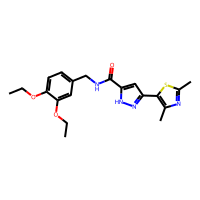
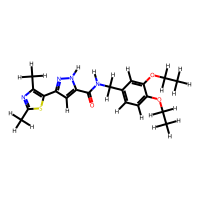
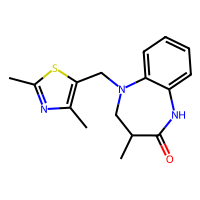
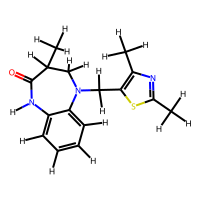
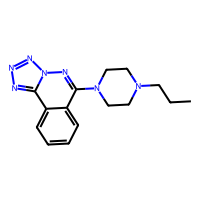
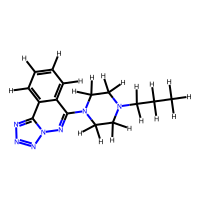
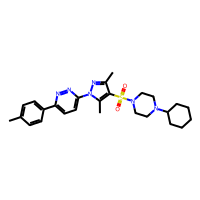
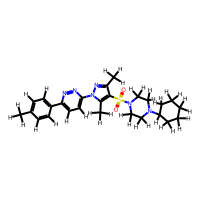
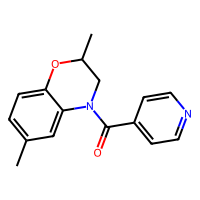
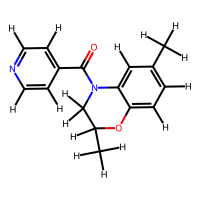
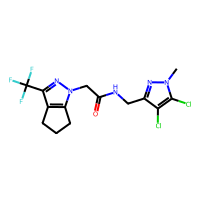
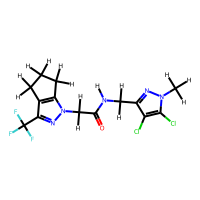
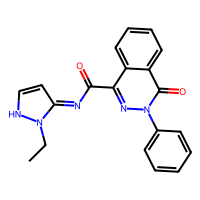
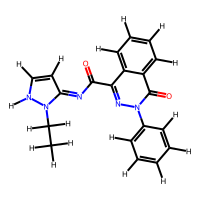
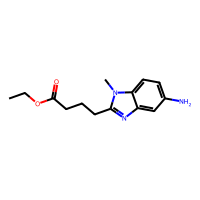
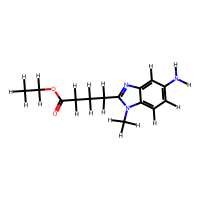
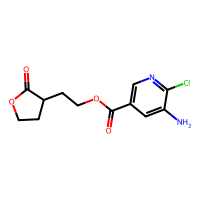
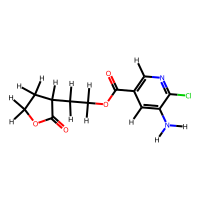
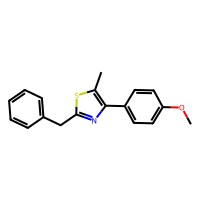
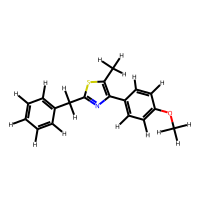

In [7]:
atomic_weights = {
    'H': 1.008, 'Li': 6.94, 'Be': 9.0122, 'B': 10.81, 'C': 12.011, 'N': 14.007, 'O': 15.999, 'F': 18.998,
    'Na': 22.990, 'Mg': 24.305, 'Al': 26.982, 'Si': 28.085, 'P': 30.974, 'S': 32.06, 'Cl': 35.45
}

natural_abundances = {
    'H': 99.98, 'Li': 92.41, 'Be': 100, 'B': 80.1, 'C': 98.9, 'N': 99.63, 'O': 99.76, 'F': 100,
    'Na': 100, 'Mg': 79, 'Al': 100, 'Si': 92.23, 'P': 100, 'S': 95.02, 'Cl': 75.78
}

atomic_radii = {
    'H': 25, 'Li': 145, 'Be': 105, 'B': 85, 'C': 70, 'N': 65, 'O': 60, 'F': 50,
    'Na': 180, 'Mg': 150, 'Al': 125, 'Si': 110, 'P': 100, 'S': 100, 'Cl': 100  # in pm
}

thermal_conductivities = {
    'H': 0.1805, 'Li': 84.8, 'Be': 190, 'B': 27.4, 'C': 119, 'N': 0.02583, 'O': 0.02658, 'F': 0.0277,
    'Na': 142, 'Mg': 156, 'Al': 237, 'Si': 149, 'P': 0.236, 'S': 0.205, 'Cl': 0.0089  # in W/(m·K)
}

heats_of_fusion = {
    'H': 0.117, 'Li': 3.00, 'Be': 7.95, 'B': 50.2, 'C': None, 'N': 0.072, 'O': 0.222, 'F': 0.510,
    'Na': 2.60, 'Mg': 8.48, 'Al': 10.7, 'Si': 50.21, 'P': 0.63, 'S': 1.717, 'Cl': 6.406  # in kJ/mol
}


In [10]:
def element_weights(molecule):
    element_counts = {}
    for atom in molecule.GetAtoms():
        element = atom.GetSymbol()
        if element in element_counts:
            element_counts[element] += 1
        else:
            element_counts[element] = 1
            
    element_weights = {key: value for key, value in element_counts.items()}
    
    return element_weights

dic_ele = element_weights(train['Molecule'][0])
dic_ele

{'C': 20, 'O': 3, 'N': 4, 'S': 1}

In [13]:
def weighted_electron_affinity(element_counts, affinities):
    total_weighted_affinity = 0
    total_count = 0
    
    for element, count in element_counts.items():
        affinity = affinities.get(element, 0)  # 해당 원소의 전자친화력
        total_weighted_affinity += affinity * count  # 전자친화력에 원소 개수를 곱함
        total_count += count 

    if total_count == 0:
        return 0  # 전체 원소 개수가 0이면 0을 반환

    return total_weighted_affinity / total_count

weighted_electron_affinity(dic_ele, electron_affinities)

110.18571428571428

In [14]:
def average_electron_affinity(element_counts, affinities):
    total_affinity = 0
    total_count = 0
    
    for element, count in element_counts.items():
        affinity = affinities.get(element, 0)  # 해당 원소의 전자친화력
        total_affinity += affinity * count  # 전자친화력에 원소 개수를 곱함
        total_count += count  # 전체 원소 개수를 계산

    if total_count == 0:
        return 0  # 전체 원소 개수가 0이면 0을 반환

    return total_affinity / total_count

average_electron_affinity(dic_ele, electron_affinities)

110.18571428571428